In [39]:
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModel
from transformers import ElectraForPreTraining, ElectraTokenizerFast
from transformers import Trainer, TrainingArguments
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import EarlyStoppingCallback
import seaborn as sns
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix

import subprocess

from matplotlib.pyplot import plot, show, savefig
import seaborn as sns
from itertools import chain


In [40]:
robe_model_name = "ufal/robeczech-base"
seznam_model_name = "Seznam/small-e-czech"

In [37]:
FILES = ["data/GEN-raw", "data/JUN-raw"]
DATA_PREPED = False

Data prep

In [38]:
if not DATA_PREPED:
    for file in FILES:
        command = ["python", "src/clean_corpus.py", file]

        try:
            result = subprocess.run(command, check=True, text=True, capture_output=True)
        except subprocess.CalledProcessError as e:
            print("Error:", e.stderr)


Data load

In [5]:
def load_data(file):
    with open(file + "-cleared.txt") as f:
        return f.read().strip().split("\n")
        
positive_sentences = load_data("data/JUN")[:100]
negative_sentences = load_data("data/GEN")[:100]


In [6]:
len(positive_sentences), len(negative_sentences)


(100, 100)

In [7]:
all_sentences = positive_sentences + negative_sentences
labels = [1] * len(positive_sentences) + [0] * len(negative_sentences)

train_indices, eval_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
valid_indices, test_indices = train_test_split(eval_indices, test_size=0.5, random_state=42)

train_sentences = [all_sentences[i] for i in train_indices]
valid_sentences = [all_sentences[i] for i in valid_indices]
test_sentences = [all_sentences[i] for i in test_indices]

train_labels = [labels[i] for i in train_indices]
valid_labels = [labels[i] for i in valid_indices]
test_labels = [labels[i] for i in test_indices]

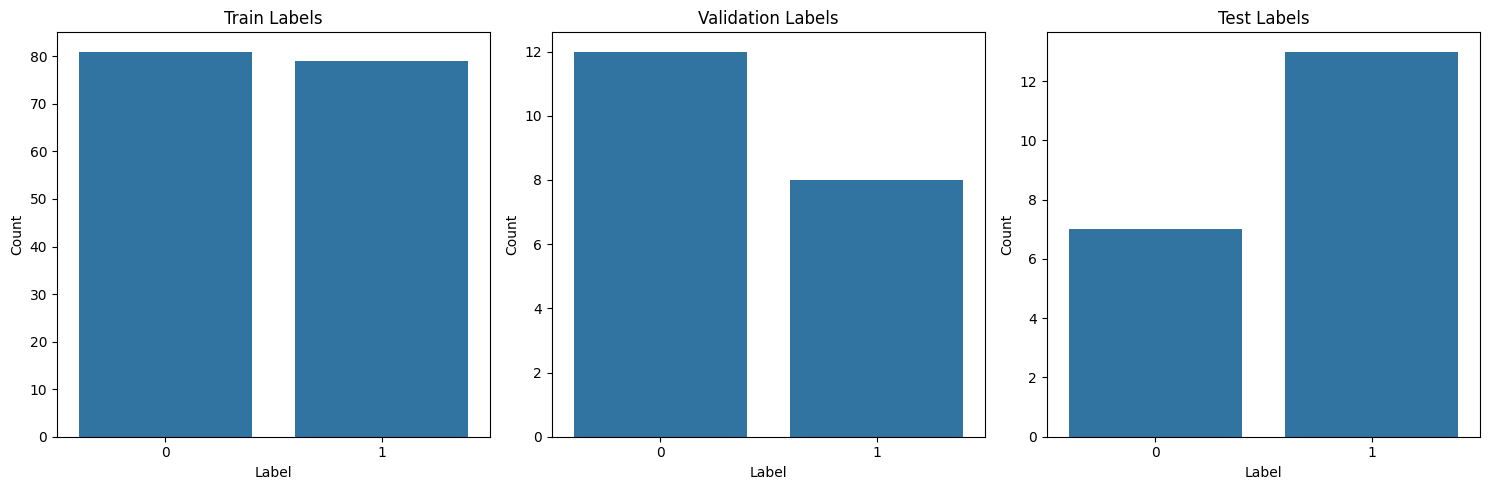

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=train_labels, ax=axs[0])
axs[0].set_title('Train Labels')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

sns.countplot(x=valid_labels, ax=axs[1])
axs[1].set_title('Validation Labels')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

sns.countplot(x=test_labels, ax=axs[2])
axs[2].set_title('Test Labels')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### Tokenize

In [9]:
tokenizer = RobertaTokenizer.from_pretrained("ufal/robeczech-base")

def tokenize(sentences, labels):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": torch.tensor(labels)}

train_data = tokenize(train_sentences, train_labels)
valid_data = tokenize(valid_sentences, valid_labels)
test_data = tokenize(test_sentences, test_labels)


#### Datasets

In [10]:
class SentenceDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

In [11]:
train_dataset = SentenceDataset(train_data)
valid_dataset = SentenceDataset(valid_data)
test_dataset = SentenceDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

### Roberta classifier

model

In [42]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51997, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [41]:
model = RobertaForSequenceClassification.from_pretrained(
    "ufal/robeczech-base", 
    num_labels=2
)
model.config.hidden_dropout_prob = 0.3  # Dropout for fully connected layers
model.config.attention_probs_dropout_prob = 0.3  # Dropout for attention layers

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizer

In [13]:
optimizer_grouped_parameters = [
    {"params": model.roberta.encoder.layer[:6].parameters(), "lr": 1e-5},  # Lower layers
    {"params": model.roberta.encoder.layer[6:].parameters(), "lr": 3e-5},  # Higher layers
    {"params": model.classifier.parameters(), "lr": 5e-5},  # Classification head
]
optimizer = AdamW(optimizer_grouped_parameters, weight_decay=0.01)

- *Use techniques like backtranslation, synonym replacement, or paraphrasing to augment your dataset, especially if it's small. Hugging Face’s nlpaug or TextAttack libraries can help.*
- *Explore different values for hyperparameters like freeze layers, learning rate, weight decay, batch size, and warmup steps. Tools like Optuna or Hugging Face’s Trainer.hyperparameter_search can automate this process.*



Trainer

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

loss_fn = CrossEntropyLoss()

early_stopping_patience = 2
best_valid_loss = float('inf')
patience_counter = 3

for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.set_postfix(loss=loss.item())

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            valid_loss += loss_fn(outputs.logits, batch["labels"]).item()

    avg_valid_loss = valid_loss / len(valid_loader)
    print(f"Validation Loss: {valid_loss / len(valid_loader)}")
    
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_tokenizer")  



Epoch 1: 100%|██████████| 10/10 [00:56<00:00,  5.63s/it, loss=0.585]


Validation Loss: 0.4629230946302414


Epoch 2: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it, loss=0.385]


Validation Loss: 0.25689755380153656


Epoch 3: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it, loss=0.263]


Validation Loss: 0.10714363493025303


Epoch 4: 100%|██████████| 10/10 [00:52<00:00,  5.29s/it, loss=0.0583]


Validation Loss: 0.08709707949310541


Epoch 5: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it, loss=0.0178]


Validation Loss: 0.08124263491481543


Epoch 6: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it, loss=0.0122]


Validation Loss: 0.1893391809426248


Epoch 7: 100%|██████████| 10/10 [00:52<00:00,  5.25s/it, loss=0.0102]


Validation Loss: 0.12905586836859584
Early stopping triggered


('./fine_tuned_tokenizer/tokenizer_config.json',
 './fine_tuned_tokenizer/special_tokens_map.json',
 './fine_tuned_tokenizer/vocab.json',
 './fine_tuned_tokenizer/merges.txt',
 './fine_tuned_tokenizer/added_tokens.json')

In [ ]:

model.eval()
predictions, probs, true_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        probs.extend(torch.softmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")
print(classification_report(true_labels, predictions))


Test Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



In [26]:
# evaluate model from test data loader
def evaluate(test_loader: DataLoader, model: RobertaForSequenceClassification):
    model.eval()
    predictions, probs, true_labels = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            probs.extend(torch.softmax(logits, dim=-1).cpu().numpy()[:, 1])
            true_labels.extend(batch["labels"].cpu().numpy())
    return predictions, probs, true_labels


In [27]:
def evaluate_classification(valid_loader: DataLoader, test_loader: DataLoader, model):
    y_pred_valid, y_pred_proba_valid, y_Valid = evaluate(valid_loader, model)
    y_pred_test, y_pred_proba_test, y_Test = evaluate(test_loader, model)

    valid_results = {
        'accuracy': accuracy_score(y_Valid, y_pred_valid),
        'f1_score': f1_score(y_Valid, y_pred_valid),
        'confusion_matrix': confusion_matrix(y_Valid, y_pred_valid),
        'classification_report': classification_report(y_Valid, y_pred_valid),
        'roc_auc': roc_auc_score(y_Valid, y_pred_proba_valid)  # Positive class probabilities
    }
    test_results = {
        'accuracy': accuracy_score(y_Test, y_pred_test),
        'f1_score': f1_score(y_Test, y_pred_test),
        'confusion_matrix': confusion_matrix(y_Test, y_pred_test),
        'classification_report': classification_report(y_Test, y_pred_test),
        'roc_auc': roc_auc_score(y_Test, y_pred_proba_test)  # Positive class probabilities
    }

    return valid_results, test_results


In [32]:
def visualize_evaluation_metrics(results, output_file: str):
    confusion_matrix = results['confusion_matrix']
    accuracy = results['accuracy']
    f1 = results['f1_score']
    roc_auc = results['roc_auc']

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
    axs[0].set_title('Confusion Matrix', fontsize=14)
    axs[0].set_xlabel('Predicted Label', fontsize=12)
    axs[0].set_ylabel('True Label', fontsize=12)

    metric_names = ['Accuracy', 'F1 Score', 'ROC-AUC']
    metric_values = [accuracy, f1, roc_auc]

    axs[1].barh(metric_names, metric_values, color=['skyblue', 'lightgreen', 'salmon'])
    axs[1].set_xlim(0, 1)
    axs[1].set_title('Metrics', fontsize=14)
    axs[1].set_xlabel('Score', fontsize=12)
    
    for i, v in enumerate(metric_values):
        axs[1].text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

    # print("\nClassification Report:\n")
    # print(results['classification_report'])

[np.float32(0.0066601965), np.float32(0.005916387), np.float32(0.99444723), np.float32(0.017686475), np.float32(0.99450314), np.float32(0.99267274), np.float32(0.994528), np.float32(0.97897506), np.float32(0.01089893), np.float32(0.005951732), np.float32(0.991742), np.float32(0.9936725), np.float32(0.99454015), np.float32(0.0072379457), np.float32(0.9931837), np.float32(0.00706604), np.float32(0.0067149475), np.float32(0.0061104237), np.float32(0.016979946), np.float32(0.008748998)]


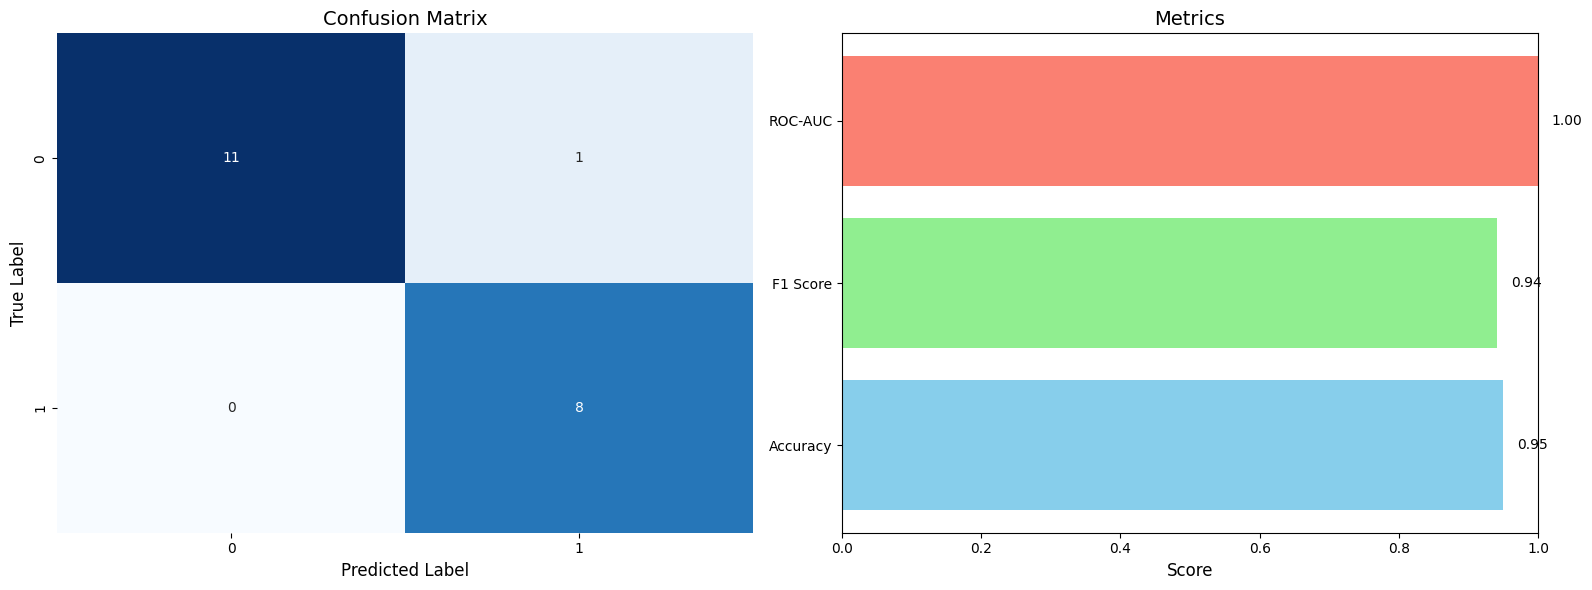

In [29]:
valid_results, test_results = evaluate_classification(valid_loader, test_loader, model)
visualize_evaluation_metrics(valid_results)
visualize_evaluation_metrics(test_results)

In [31]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    probs = torch.softmax(logits, dim=-1)[:, 1]

    # show sentences from batch with predicted labels and true labels
    for sentence, pred, prob, true in zip(batch["input_ids"], predictions, probs, batch["labels"]):
        print(f"Sentence: {tokenizer.decode(sentence, skip_special_tokens=True)}")
        print(f"Predicted Label: {pred.item()} with probability {prob.item()}")
        print(f"True Label: {true.item()}")
        print()
    break

Sentence: " Carlotto !
Predicted Label: 1 with probability 0.9682776927947998
True Label: 1

Sentence: Taková projížďka na čerstvém vzduchu mu dozajista prospěje .
Predicted Label: 1 with probability 0.9930729269981384
True Label: 1

Sentence: Zelektrizované tělo si třel o břitkou dřevnatou trávu a dožadoval se nadrženým skučením stále větších nánosů popela .
Predicted Label: 0 with probability 0.006828409153968096
True Label: 0

Sentence: Při troše štěstí narazíme na nějakýho dostatečně neukázněnýho skinhedskýho řidiče , kterej nemůže barevný přistěhovalce vystát .
Predicted Label: 1 with probability 0.9944573640823364
True Label: 1

Sentence: Ten pohled byl děsnější než krok do prázdna .
Predicted Label: 0 with probability 0.0100464578717947
True Label: 0

Sentence: Provázel je široký mrtvý pás , ve kterém mě míjely jenom vyhaslé včelíny , rotující demižony zkvašeného vína , ošatky blínu a čínské vázy s obrazy draků .
Predicted Label: 0 with probability 0.006894402671605349
True Labe

In [ ]:
def predict(text):
    encoding = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    output = model(**encoding)
    return torch.argmax(output.logits).item()

### Custom Roberta classifier

In [17]:
class CustomRobertaClassifier(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(CustomRobertaClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(base_model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_embedding)
        return logits

model = CustomRobertaClassifier(robe_model_name, num_labels=2)

optimizer = AdamW([
    {"params": model.roberta.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
])

class ExampleDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained(robe_model_name)
dataset = ExampleDataset(tokenizer, ["Example sentence 1", "Example sentence 2"], [0, 1])
dataloader = DataLoader(dataset, batch_size=2)

# Training loop
model.train()
for epoch in range(3):
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()


Some weights of RobertaModel were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### RobeCzech

load model

In [9]:
robe_model = AutoModel.from_pretrained(robe_model_name)


Some weights of RobertaModel were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Seznam.cz

In [ ]:
discriminator = ElectraForPreTraining.from_pretrained(seznam_model_name)
tokenizer = ElectraTokenizerFast.from_pretrained(seznam_model_name)

sentence = "Za hory, za doly, mé zlaté parohy"
fake_sentence = "Za hory, za doly, kočka zlaté parohy"

fake_sentence_tokens = ["[CLS]"] + tokenizer.tokenize(fake_sentence) + ["[SEP]"]
fake_inputs = tokenizer.encode(fake_sentence, return_tensors="pt")

# Get outputs including hidden states
outputs = discriminator(fake_inputs, output_hidden_states=True)

# Access hidden states (a tuple of embeddings for all layers)
hidden_states = outputs.hidden_states

# Select the hidden layer embedding you want (e.g., the last hidden layer)
last_hidden_state = hidden_states[-1]  # Shape: (batch_size, seq_len, hidden_size)

# Extract embedding for [CLS] token (if used for classification tasks)
cls_embedding = last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

: 

### Own classifier

#### Raw embeddings

In [7]:
def get_embeddings():
    with torch.no_grad():
        outputs = robe_model(**encodings_raw)
        last_hidden_state = outputs.last_hidden_state

        cls_embedding = last_hidden_state[:, 0, :]

        attention_mask = encodings['attention_mask']
        sentence_embeddings = (
            (last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) /
            attention_mask.sum(dim=1, keepdim=True)
        )


dataset

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'embedding': self.embeddings[idx],
            'label': self.labels[idx]
        }
        
sentence_embeddings_train_indices, sentence_embeddings_eval_indices = train_test_split(range(len(sentence_embeddings)), test_size=0.2, random_state=42)

train_dataset = EmbeddingDataset(sentence_embeddings[sentence_embeddings_train_indices], torch.tensor(labels)[sentence_embeddings_train_indices])
eval_dataset = EmbeddingDataset(sentence_embeddings[sentence_embeddings_eval_indices], torch.tensor(labels)[sentence_embeddings_eval_indices])


model

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, hidden_size=768):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

classifier = BinaryClassifier()

logits = classifier(cls_embedding)



fine-tuning

In [ ]:
# Define the training arguments (you can adjust these based on your needs)
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Define a Trainer instance
trainer = Trainer(
    model=classifier,               # our custom binary classifier
    args=training_args,             # training arguments
    train_dataset=train_dataset,    # you need to prepare this
    eval_dataset=eval_dataset,      # you need to prepare this
)

# Train the model
trainer.train()
